# Creating the Boundary Conditions

This notebook serves as a demo for the creation of model boundary conditions. These boundary conditions are shown for my Antarctica Temperature regional model. You can follow and/or adapt this notebook based on your configuration if you are using a regional domain.

First, import packages to re-create and visualize the model fields here:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4

Next, define the location of the input directory for the model. This is the same directory that holds the bathymetry file generated in the previous notebooks for this model example.

In [2]:
# define the input directory
input_dir = '/Users/eddie/Documents/CS185C/Project/input'

## Constructing the Boundary Conditions
For my model, I will use a model state from the ECCO Version 5 state estimate. I will prepare the boundary condition fields in 7 steps:
1. download 5 fields and 4 grid files generated by the ECCO model in 2017 and 2007
2. read the ECCO model grid
3. read in the bathymetry for my model as well as its grid
4. prepare the ECCO fields for interpolation
5. interpolate the ECCO fields onto my model grid and store each as a binary file
6. plot the interpolated fields to ensure they look as expected
7. prepare notes on the run-time options I will use to implement my approach

### Step 1: Download the ECCO fields
To begin, I downloaded the model fields generated by the ECCO Version 5 Alpha state estimate. These fields are available [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/nctiles_monthly). In particular, I downloaded the following list of files that contain the field pertaining to time span of my model (2007 and 2017):

| Variable | File Name |
| -------- | --------- |
|THETA|THETA/THETA_200[7/17].nc|
|SALT|SALT/SALT_200[7/17].nc|
|UVEL|UVELMASS/UVELMASS_200[7/17].nc|
|VVEL|VVELMASS/VVELMASS_200[7/17].nc|

I stored these fields in the following directory:

In [3]:
data_folder = '/Users/eddie/Documents/CS185C/Project/input/data'

### Step 2: Read in the ECCO grid
To read in the ECCO fields, I will rely on the `grid` module from the `eccoseas.ecco` package [HERE](https://github.com/mhwood/eccoseas), which I import here:

In [4]:
from eccoseas.ecco import grid

In [5]:
ecco_XC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='XC')
ecco_YC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='YC')
ecco_hFacC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacC')
ecco_hFacW_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacW')
ecco_hFacS_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacS')
ecco_RF_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='RF')

As described [HERE](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Plotting_Tiles.html), the ECCO grid has 13 tiles but only 1 or 2 may pertain to my local area. To determine which tiles correspond to my region, I'll read in my model grid next.

### Step 3: Read in the Model Grid and Generate a Mask
Here, I will recreate the grid I will use in my model and read in the bathymetry file (see previous notebooks for details):

In [6]:
# define the parameters that will be used in the data file
delX = 1/12
delY = 1/12
xgOrigin = -80
ygOrigin = -80
n_rows = 360
n_cols = 360

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'Antarctica_bathymetry.bin'),'>f4').reshape(np.shape(XC))

With an eye toward the interpolation to come next, I will make a mask to determine where the interpolatation will take place. I will create this mask by recreating the `hFac` field for my model using the `hFac` module from the `eccoseas` package: 

In [7]:
from eccoseas.downscale import hFac

In [8]:
depth = bathy
delR = np.array([ 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.01,
                 10.03, 10.11, 10.32, 10.80, 11.76, 13.42, 16.04, 19.82, 24.85,
                 31.10, 38.42, 46.50, 55.00, 63.50, 71.58, 78.90, 85.15, 90.18,
                 93.96, 96.58, 98.25, 99.25,100.01,101.33,104.56,111.33,122.83,
                 139.09,158.94,180.83,203.55,226.50,249.50,272.50,295.50,318.50,
                 341.50,364.50,387.50,410.50,433.50,456.50,])
Z = np.cumsum(delR)
hFacC = hFac.create_hFacC_grid(depth, delR)

The mask is generated by setting all of the non-zero `hFac` points to 1:

In [9]:
mask = np.copy(hFacC)
mask[mask>0] = 1

To double check the mask was created as expected, I will plot it in comparison to the bathymetry here:

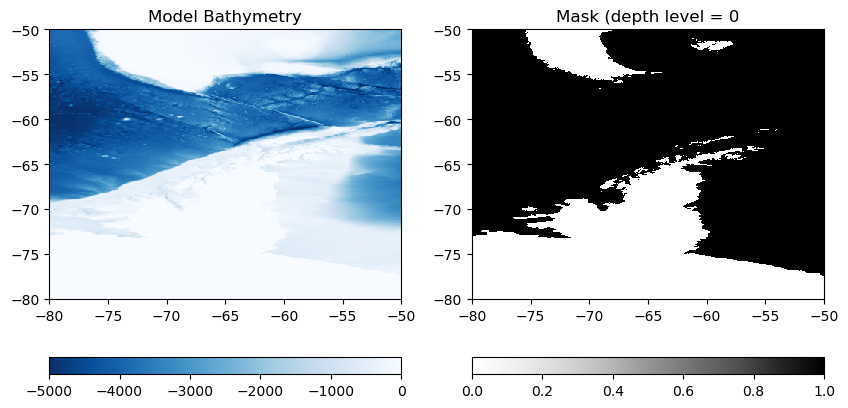

In [10]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

depth_level = 0
plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, mask[0], vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Mask (depth level = '+str(depth_level))

plt.show()

Seems reasonable!

### Step 4: Prepare the grids for interpolation
At this point, we can use the geometry of both grids to check to see which tiles have the information we need. After some trial and error (and referencing the ECCO page), I find that tiles 12 and 13 have the points I need:

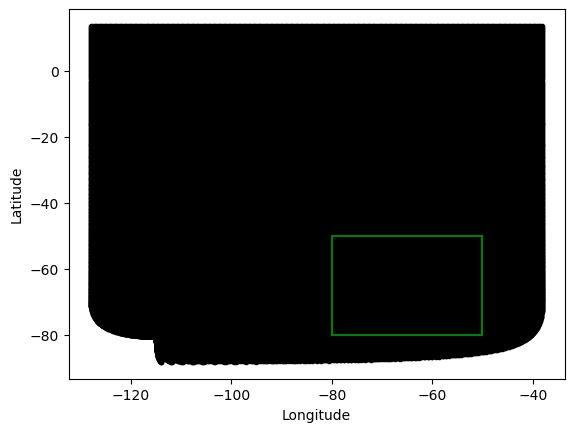

In [11]:
# plot the ECCO tile points from tiles 12 and 11
plt.plot(ecco_XC_tiles[12],ecco_YC_tiles[12],'k.')
plt.plot(ecco_XC_tiles[13],ecco_YC_tiles[13],'k.')

# plot the boundary of the CA model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

As we can see, my model boundary (green) is completely surrounded by the points in tile 12 and 13 (black). Given these observations, now I read in points from just those tiles to use in interpolation:

In [12]:
tile_list = [12,13]

# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_hFacC_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacW_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacS_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_mask_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()
    
    for k in range(np.size(ecco_RF_tiles[tile_number])):
        level_hFacC = ecco_hFacC_tiles[tile_number][k, :, :]
        level_hFacW = ecco_hFacW_tiles[tile_number][k, :, :]
        level_hFacS = ecco_hFacS_tiles[tile_number][k, :, :]
        level_mask = np.copy(level_hFacC)
        level_mask[level_mask>0] = 1
        ecco_hFacC_points[k, points_counted:points_counted+tile_N] = level_hFacC.ravel()
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        ecco_mask_points[k,points_counted:points_counted+tile_N] = level_mask.ravel()
    
    points_counted += tile_N

# remove the points with positive longitude
local_indices = ecco_XC_points<0
ecco_mask_points = ecco_mask_points[:, local_indices]
ecco_hFacC_points = ecco_hFacC_points[:, local_indices]
ecco_hFacW_points = ecco_hFacW_points[:, local_indices]
ecco_hFacS_points = ecco_hFacS_points[:, local_indices]
ecco_YC_points = ecco_YC_points[local_indices]
ecco_XC_points = ecco_XC_points[local_indices]

Next, we'll read in the real data fields and apply the modifications. First, create a dictionary to store the file names:

In [13]:
# make a file dictionary to loop over

year = 2017
# year = 2007

# test dictionary
file_prefix_dict = {'THETA':'THETA_'+str(year)+'.nc'}

# # once tested with the above dict, run and comment with this one
file_prefix_dict = {'THETA':'THETA_'+str(year)+'.nc',
                    'SALT':'SALT_'+str(year)+'.nc',
                    'UVEL':'UVELMASS_'+str(year)+'.nc',
                    'VVEL':'VVELMASS_'+str(year)+'.nc'}
variable_names = list(file_prefix_dict.keys())

Now, read the fields from the same tiles:

In [14]:
# make a list to hold all of the ECCO grids
init_grids = []
timesteps = 12 # data is monthly

# loop through each variable to read in the grid
for variable_name in variable_names:
    
    if variable_name == 'ETAN':
        ds = nc4.Dataset(os.path.join(data_folder,file_prefix_dict[variable_name]))
        grid = ds.variables[variable_name][:,:,:,:]
        ds.close()
    elif 'VEL' in variable_name:
        ds = nc4.Dataset(os.path.join(data_folder,'UVELMASS_'+str(year)+'.nc'))
        u_grid = ds.variables['UVELMASS'][:,:,:,:,:]
        ds.close()
        ds = nc4.Dataset(os.path.join(data_folder,'VVELMASS_'+str(year)+'.nc'))
        v_grid = ds.variables['VVELMASS'][:,:,:,:,:]
        ds.close()
    else:
        ds = nc4.Dataset(os.path.join(data_folder,file_prefix_dict[variable_name]))
        grid = ds.variables[variable_name][:,:,:,:,:]
        ds.close()
    
    # create a grid of zeros to fill in
    N = np.shape(grid)[-1]*np.shape(grid)[-2]
    if variable_name == 'ETAN':
        init_grid = np.zeros((timesteps, 1, N*len(tile_list)))
    else:
        init_grid = np.zeros((timesteps, np.size(ecco_RF_tiles[1]), N*len(tile_list)))

    # loop through the tiles
    for t in range(timesteps):
        points_counted = 0
        for tile_number in tile_list:
            if variable_name == 'ETAN':
                init_grid[t, points_counted:points_counted+N] = \
                     grid[t, tile_number-1, :, :].ravel()
            elif 'VEL' in variable_name: # when using velocity, need to consider the tile rotations
                if variable_name == 'UVEL':
                    if tile_number<7:
                        for k in range(np.size(ecco_RF_tiles[1])):
                            init_grid[t, k,points_counted:points_counted+N] = \
                                 u_grid[t, k, tile_number-1, :, :].ravel()
                    else:
                        for k in range(np.size(ecco_RF_tiles[1])):
                            init_grid[t, k,points_counted:points_counted+N] = \
                                 v_grid[t, k, tile_number-1, :, :].ravel()
                if variable_name == 'VVEL':
                    if tile_number<7:
                        for k in range(np.size(ecco_RF_tiles[1])):
                            init_grid[t,k,points_counted:points_counted+N] = \
                                 v_grid[t, k, tile_number-1, :, :].ravel()
                    else:
                        for k in range(np.size(ecco_RF_tiles[1])):
                            init_grid[t,k,points_counted:points_counted+N] = \
                                 -1*u_grid[t, k, tile_number-1, :, :].ravel()
            else:
                for k in range(np.size(ecco_RF_tiles[1])):
                    init_grid[t,k,points_counted:points_counted+N] = \
                     grid[t, k, tile_number-1, :, :].ravel()
            points_counted += N

    # remove the points with positive longitudes
    init_grid = init_grid[:,:,local_indices]

    # apply some corrections
    if variable_name == 'UVEL':
        for t in range(timesteps):
            for k in range(np.size(ecco_RF_tiles[1])):
                non_zero_indices = ecco_hFacW_points[k,:]!=0
                init_grid[t,k,non_zero_indices] = init_grid[t,k,non_zero_indices]/(ecco_hFacW_points[k,non_zero_indices])
    if variable_name == 'VVEL':
        for t in range(timesteps):
            for k in range(np.size(ecco_RF_tiles[1])):
                non_zero_indices = ecco_hFacS_points[k,:]!=0
                init_grid[t,k,non_zero_indices] = init_grid[t,k,non_zero_indices]/(ecco_hFacS_points[k,non_zero_indices])
    
    init_grids.append(init_grid)

### Step 5: Interpolate the Fields onto the Model Grid
Next, I will interpolate the ECCO external fields I read in onto my model domain. I will use the `horizonal` module from the `eccoseas` package to accomplish this interpolation.

In [15]:
# define the boundary list for the model
boundary_list = ['west','south','north']

In [16]:
if 'obcs' not in os.listdir(input_dir):
    os.mkdir(os.path.join(input_dir,'obcs'))

In [17]:
from eccoseas.downscale import horizontal

In [18]:
if 'obcs' not in os.listdir(input_dir):
    os.mkdir(os.path.join(input_dir,'obcs'))

In [19]:
# loop through each boundary
for boundary in boundary_list:

    if boundary == 'west':
        boundary_XC = XC[:,:1]
        boundary_YC = YC[:,:1]
        boundary_mask = mask[:,:,:1]
    elif boundary == 'east':
        boundary_XC = XC[:,-1:]
        boundary_YC = YC[:,-1:]
        boundary_mask = mask[:,:,-1:]
    elif boundary == 'north':
        boundary_XC = XC[-1:,:]
        boundary_YC = YC[-1:,:]
        boundary_mask = mask[:,-1:,:]
    elif boundary == 'south':
        boundary_XC = XC[:1,:]
        boundary_YC = YC[:1,:]
        boundary_mask = mask[:,:1,:]
    else:
        raise ValueError('Boundary '+boundary+' not recognized')

    # loop through each variable and corresponding ECCO grid
    for variable_name, init_grid in zip(variable_names, init_grids):

        output_grid = np.zeros((timesteps, np.size(delR), np.size(boundary_XC)))
    
        # print a message to keep track of which variable we are working on
        # uncomment to use
        print('    - Interpolating the '+variable_name+' grid')

        for t in range(timesteps):
            interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
                                                               init_grid[t,:,:], ecco_mask_points, 
                                                               boundary_XC, boundary_YC, boundary_mask)
            for k in range(len(delR)):
                output_grid[t,k,:] = interpolated_grid[k,:,:].ravel()
    
        # output the interpolated grid
        output_file = os.path.join(input_dir,'obcs',variable_name+'_'+boundary+'_'+str(year))
        output_grid.ravel('C').astype('>f4').tofile(output_file)

    - Interpolating the THETA grid
    - Interpolating the SALT grid
    - Interpolating the UVEL grid
    - Interpolating the VVEL grid
    - Interpolating the THETA grid
    - Interpolating the SALT grid
    - Interpolating the UVEL grid
    - Interpolating the VVEL grid
    - Interpolating the THETA grid
    - Interpolating the SALT grid
    - Interpolating the UVEL grid
    - Interpolating the VVEL grid


### Step 6: Plotting the Boundary Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

In [20]:
meta_dict = {'THETA':[6, 18, 'turbo', 'm'],
            'SALT':[32, 35, 'viridis', 'm'],
            'UVEL':[-0.1, 0.1, 'seismic', 'm'],
            'VVEL':[-0.1, 0.1, 'seismic', 'm']}

Then, I'll create all of the subplots:

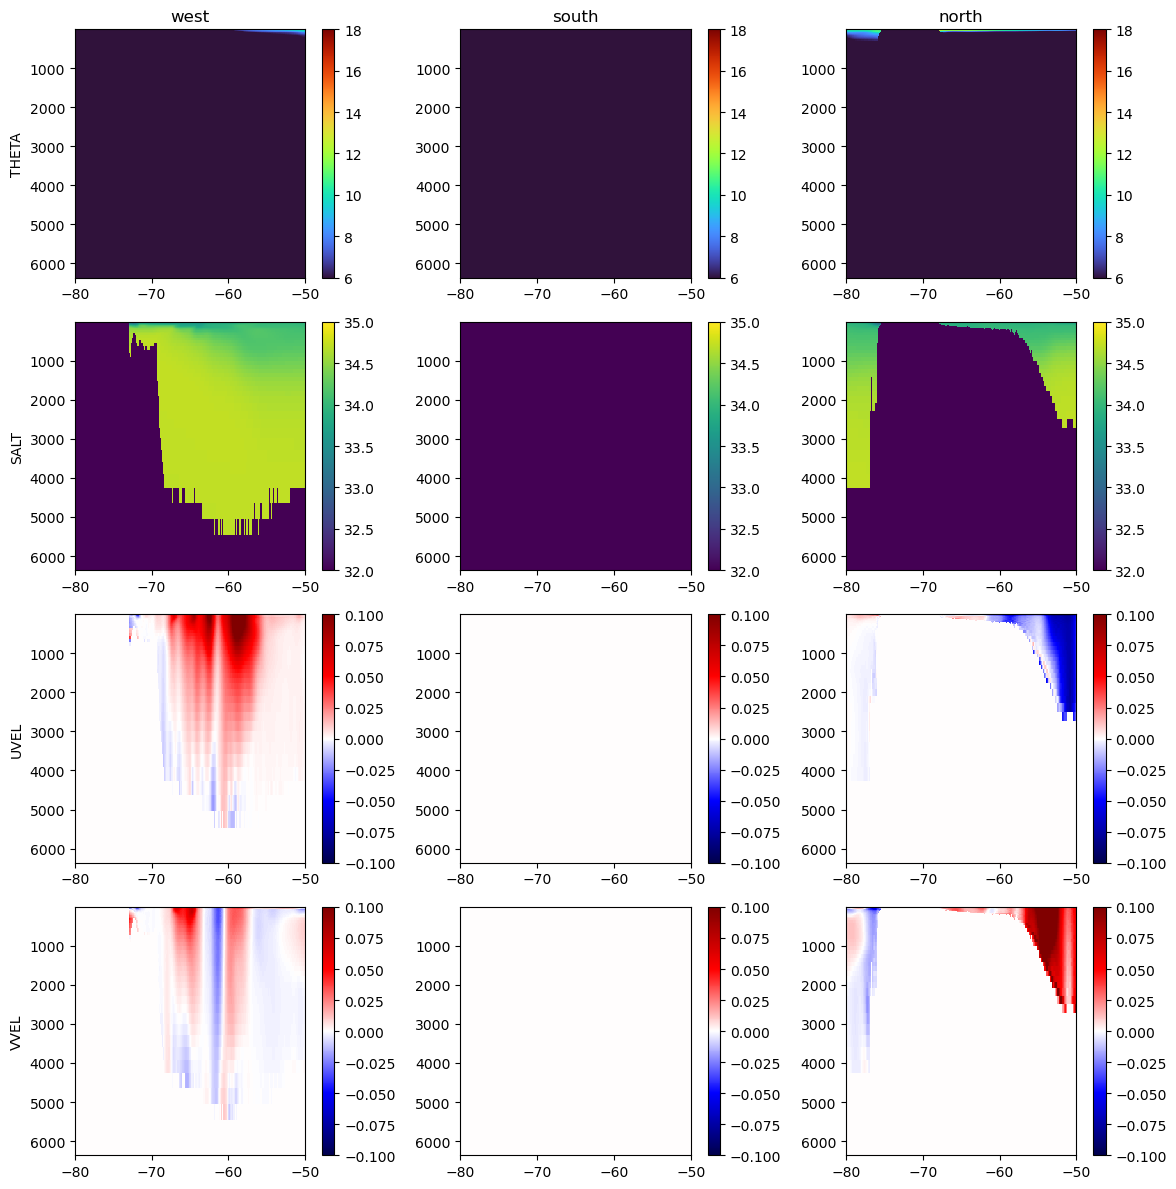

In [21]:
fig = plt.figure(figsize=(12,12))


plot_counter = 0
for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    for boundary in boundary_list:
        
        boundary_grid = np.fromfile(os.path.join(input_dir,'obcs',variable_name+'_'+boundary+'_2017'),'>f4')
    
        if boundary in ['west','east']:
            boundary_grid = boundary_grid.reshape((timesteps, np.shape(delR)[0],np.shape(XC)[0]))
            boundary_grid = boundary_grid[0, :, :] # choose just the first timestep for plotting
            if boundary=='west':
                x = YC[:,1]
            if boundary=='east':
                x = YC[:,-1]
        else:
            boundary_grid = boundary_grid.reshape((timesteps, np.shape(delR)[0],np.shape(XC)[1]))
            boundary_grid = boundary_grid[0, :, :] # choose just the first timestep for plotting
            if boundary=='north':
                x = XC[-1,:]
            if boundary=='south':
                x = XC[1,:]

        plot_counter += 1
        plt.subplot(len(variable_names),len(boundary_list),plot_counter)
        C = plt.pcolormesh(x, Z, boundary_grid,
                           vmin=meta_dict[variable_names[i]][0],
                           vmax=meta_dict[variable_names[i]][1],
                           cmap=meta_dict[variable_names[i]][2])
        plt.colorbar(C,fraction=0.26)
        plt.gca().invert_yaxis()
    
        if plot_counter%3==1:
            plt.ylabel(variable_name)
        if plot_counter<4:
            plt.title(boundary)

plt.tight_layout()

plt.show()

Looks good! Now, with the initial conditions, external forcing conditions, and boundary conditions we are nearly ready to start testing the model!

### Step 7: Run-time considerations
To use the grids as boundary conditions in the model, I will use the `obcs` package - short for Open Boundary Condtions. To ensure the boundary conditions are included in the model, I will add a line for `obcs` in my `code/packages.conf` compile time file.

Next, I will add a line with ` useOBCS=.TRUE.` to the `data.pkg` file and a new file called `data.obcs` to my run directory. See Canvas for an editable `data.obcs` file.